In [2]:
from random import sample
from pymdp import utils
import numpy as np
from pymdp.agent import Agent
from pymdp.maths import softmax, spm_log_single
import copy

num_observations = 4  # ((1, -2, 2, 0) reward levels
num_actions = 2  # cooperate, cheat
num_states = (4, 2)  # ((the possible combinations), (procosial, antisocial))
# (cooperate & cooperate): ++, (cooperate & defect): +-, (defect&cooperate): -+ , (defect&defect): --

num_modalities = 1
num_factors = 2

precision_prosocial = 3.0
precision_antisocial = 2.0

In [3]:
import numpy as np
from pymdp.maths import softmax
from pymdp import utils

def construct_A(precision_prosocial=3.0, precision_antisocial=2.0):
    A1_prosocial = np.zeros((4, 4))
    A1_prosocial[:, 0] = softmax(precision_prosocial * np.array([1, 0, 0, 0]))
    A1_prosocial[:, 1] = softmax(precision_antisocial * np.array([0, 1, 0, 0]))
    A1_prosocial[:, 2] = softmax(precision_prosocial * np.array([0, 0, 1, 0]))
    A1_prosocial[:, 3] = softmax(precision_antisocial * np.array([0, 0, 0, 1]))

    A1_antisocial = np.zeros((4, 4))
    A1_antisocial[:, 0] = softmax(
        precision_antisocial * np.array([1, 0, 0, 0])
    )
    A1_antisocial[:, 1] = softmax(precision_prosocial * np.array([0, 1, 0, 0]))
    A1_antisocial[:, 2] = softmax(
        precision_antisocial * np.array([0, 0, 1, 0])
    )
    A1_antisocial[:, 3] = softmax(precision_prosocial * np.array([0, 0, 0, 1]))
    A = utils.obj_array(1)

    A1 = np.zeros((4, 4, 2))
    A1[:, :, 0] = A1_prosocial
    A1[:, :, 1] = A1_antisocial
    A[0] = A1
    return A


def sample_action_policy_directly(q_pi, policies, num_controls, style = "deterministic"):

    num_factors = len(num_controls)

    if style == "deterministic":
        policy_idx = np.argmax(q_pi)
    elif style == "stochastic":
        policy_idx = utils.sample(q_pi)
    
    selected_policy = np.zeros(num_factors)
    for factor_i in range(num_factors):
        selected_policy[factor_i] = policies[policy_idx][0, factor_i]

    return selected_policy

def get_observation(action_1, action_2):
    action_1 == int(action_1)
    action_2 = int(action_2)
    if action_1 == 0 and action_2 == 0:
        return [0]
    elif action_1 == 0 and action_2 == 1:
        return [1]
    elif action_1 == 1 and action_2 == 0:
        return [2]
    elif action_1 == 1 and action_2 == 1:
        return [3]


def print_A(A):
    print("A1: observation of reward to reward states")
    print(A[0])
    print(A[0].shape)
    print(A[0][3, :, :])

    print()


def print_B(B):
    print("B1: transitions from reward states given action cooperate")
    print(B[0][:, :, 0])
    print()
    print("B1: transitions from reward states given action cheat")
    print(B[0][:, :, 1])

    print("B2: transitions from cooperation states given action cooperate")
    print(B[1][:, :, 0])
    print()
    print("B2: transitions from cooperation states given action cheat")
    print(B[1][:, :, 1])


In [4]:
""" The probability of being in reward states cc or dc are more likely if the neighbour is prosocial"""

A = construct_A(precision_prosocial, precision_antisocial)

# print_A(A)

B = utils.obj_array(num_factors)
B_1 = np.ones((4, 4, 2)) * 0.5
B_1[2:, :, 0] = 0.0
B_1[:2, :, 1] = 0.0
B[0] = B_1

B_2 = np.zeros((2, 2, 2))
# B_2[:, :, 0] = np.array(
#     [
#         [0.8, 0.4],  # given that i cooperated, the probability p (s = prosocial | s_t=1 = prosocial)
#         [0.2, 0.6],
#     ] )

B_2[:, :, 0] = np.array(
    [
        [0.5, 0.5],  # given that i cooperated, the probability p (s = prosocial | s_t=1 = prosocial)
        [0.5, 0.5],
    ] )

B_2[:, :, 1] = np.array(
    [
        [0.5, 0.5],  # given that i cooperated, the probability p (s = prosocial | s_t=1 = prosocial)
        [0.5, 0.5],
    ] )

# B_2[:, :, 1] = np.array([[0.6, 0.2], [0.4, 0.8]])

B[1] = B_2


In [8]:
C = utils.obj_array(num_modalities)
C[0] = np.array([4, 1, 4, 3])
lr_pb = 0.25

D = utils.obj_array(num_factors)

D[0] = np.array([0.25, 0.25, 0.25, 0.25])
D[1] = np.array([0.5, 0.5])

# pB_1 = utils.dirichlet_like(B)

# pB_2 = utils.dirichlet_like(B)

# agent_1 = Agent(A=A, B=B, C=C, D=D, pB=pB_1, lr_pB=10, factors_to_learn=[0])
# agent_2 = Agent(A=A, B=B, C=C, D=D, pB=pB_2, lr_pB=10, factors_to_learn=[0])

# agent_1 = Agent(A=A, B=B, C=C, D=D, pB=pB_1, lr_pB=10)
# agent_2 = Agent(A=A, B=B, C=C, D=D, pB=pB_2, lr_pB=10)

agent_1 = Agent(A=A, B=B, C=C, D=D, policies = [np.array([[0,0]]), np.array([[1, 1]])])
agent_2 = Agent(A=A, B=B, C=C, D=D, policies = [np.array([[0,0]]), np.array([[1, 1]])])

""" We don't allow policies [1,0] or [0,1]"""
# agent_1.policies = [agent_1.policies[0], agent_1.policies[3]]

# agent_1.policies[1] = agent_1.policies[0]
# agent_1.policies[2] = agent_1.policies[3]
# agent_2.policies[1] = agent_2.policies[0]
# agent_2.policies[2] = agent_2.policies[3]

" We don't allow policies [1,0] or [0,1]"

In [9]:
observation_1 = [0]
observation_2 = [0]
actions = ["cooperate", "cheat"]

qs_prev_1 = copy.deepcopy(D)
qs_prev_2 = copy.deepcopy(D)

observation_names1 = ["cc", "cd", "dc", "dd"]
observation_names2 = ["prosocial", "antisocial"]

action_names = ["cooperate", "cheat"]

T = 50

actions_over_time = np.zeros((T, 2))
B_over_time = np.zeros((T, 2, 4, 2))
q_pi_over_time = np.zeros((T, 2, 2))


In [7]:
t = 0
qs_1 = agent_1.infer_states(observation_1)
qs_2 = agent_2.infer_states(observation_2)


In [154]:
q_pi_1, efe_1 = agent_1.infer_policies()
q_pi_2, efe_2 = agent_2.infer_policies()

In [135]:
action_1 = sample_action_policy_directly(
        q_pi_1, agent_1.policies, agent_1.num_controls
    )
action_2 = sample_action_policy_directly(
    q_pi_2, agent_2.policies, agent_2.num_controls
)

In [136]:
action_1 = action_1[1]
action_2 = action_2[1]
actions_over_time[t] = [action_1, action_2]

observation_1 = get_observation(action_1, action_2)
observation_2 = get_observation(action_2, action_1)

In [ ]:
num_trials = 100
T_per_trial = 2

for t in range(T):

    for t > 0

        o_t = get_observation(action)
        q_s = infer_states(o_t)
        update_B(qs_now = q_s, qs_prev = qs_prev)

        q_pi = infer_policies(q_s)
        action = sample_action(q_pi)
        q_s_prev = q_s

In [10]:

for t in range(T):
    print(f"time = : {t}")

    qs_1 = agent_1.infer_states(observation_1)
    qs_2 = agent_2.infer_states(observation_2)

    qB_1 = agent_1.update_B(qs_prev_1)
    qB_2 = agent_2.update_B(qs_prev_2)
    """
    print("observations")
    print(observation_1)
    print(observation_2)
    print("AGENT 1 A")

    print(A[0][int(observation_1[0]),:])
    print("AGENT 2 A")

    print(A[0][int(observation_2[0]),:])
    print("qs")
    print(qs_1)
    print(qs_2)
    print()
    """
    q_pi_1, efe_1 = agent_1.infer_policies()
    q_pi_2, efe_2 = agent_2.infer_policies()
    # print("q_pi")
    # print(q_pi_1)
    # print()
    # action_1 = agent_1.sample_action()
    # action_2 = agent_2.sample_action()
    action_1 = sample_action_policy_directly(
        q_pi_1, agent_1.policies, agent_1.num_controls, style = "deterministic"
    )
    action_2 = sample_action_policy_directly(
        q_pi_2, agent_2.policies, agent_2.num_controls, style = "deterministic"
    )
    agent_1.action = action_1
    agent_2.action = action_2

    action_1 = action_1[1]
    action_2 = action_2[1]
    actions_over_time[t] = [action_1, action_2]

    

    observation_1 = get_observation(action_1, action_2)
    observation_2 = get_observation(action_2, action_1)
    """
    print("AGENT 1 B")
    print(agent_1.B[0][:,int(observation_1[0]),0])
    print(agent_1.B[0][:,int(observation_1[0]),1])
    print("AGENT 2 B")
    print(agent_2.B[0][:,int(observation_2[0]),0])
    print(agent_2.B[0][:,int(observation_2[0]),1])
    """
    # B_over_time[t, 0, :, 0] = agent_1.B[0][:, int(observation_1[0]), 0]
    # B_over_time[t, 1, :, 0] = agent_1.B[0][:, int(observation_1[0]), 1]
    # B_over_time[t, 0, :, 1] = agent_2.B[0][:, int(observation_2[0]), 0]
    # B_over_time[t, 1, :, 1] = agent_2.B[0][:, int(observation_2[0]), 1]

    # B1_over_time[t,:,:,:,0] = agent_1.B[0]
    # B1_over_time[t,:,:,:,0] = agent_2.B[0]

    # B2_over_time[t,:,:,:,0] = agent_1.B[1]
    # B2_over_time[t,:,:,:,0] = agent_2.B[1]

    # q_pi_over_time[t, :, 0] = [q_pi_1[0], q_pi_1[3]]
    # q_pi_over_time[t, :, 1] = [q_pi_2[0], q_pi_2[3]]

    # num_factors = len(pB_1)

    # qB = copy.deepcopy(pB_1)

    # qB_1 = agent_1.update_B(qs_prev_1)
    # qB_2 = agent_2.update_B(qs_prev_2)


time = : 0
q_pi
[0.5 0.5]

time = : 1
q_pi
[0.5 0.5]

time = : 2
q_pi
[0.5 0.5]

time = : 3
q_pi
[0.5 0.5]

time = : 4
q_pi
[0.5 0.5]

time = : 5
q_pi
[0.5 0.5]

time = : 6
q_pi
[0.5 0.5]

time = : 7
q_pi
[0.5 0.5]

time = : 8
q_pi
[0.5 0.5]

time = : 9
q_pi
[0.5 0.5]

time = : 10
q_pi
[0.5 0.5]

time = : 11
q_pi
[0.5 0.5]

time = : 12
q_pi
[0.5 0.5]

time = : 13
q_pi
[0.5 0.5]

time = : 14
q_pi
[0.5 0.5]

time = : 15
q_pi
[0.5 0.5]

time = : 16
q_pi
[0.5 0.5]

time = : 17
q_pi
[0.5 0.5]

time = : 18
q_pi
[0.5 0.5]

time = : 19
q_pi
[0.5 0.5]

time = : 20
q_pi
[0.5 0.5]

time = : 21
q_pi
[0.5 0.5]

time = : 22
q_pi
[0.5 0.5]

time = : 23
q_pi
[0.5 0.5]

time = : 24
q_pi
[0.5 0.5]

time = : 25
q_pi
[0.5 0.5]

time = : 26
q_pi
[0.5 0.5]

time = : 27
q_pi
[0.5 0.5]

time = : 28
q_pi
[0.5 0.5]

time = : 29
q_pi
[0.5 0.5]

time = : 30
q_pi
[0.5 0.5]

time = : 31
q_pi
[0.5 0.5]

time = : 32
q_pi
[0.5 0.5]

time = : 33
q_pi
[0.5 0.5]

time = : 34
q_pi
[0.5 0.5]

time = : 35
q_pi
[0.5 0.5]

ti

Text(0.5, 1.0, 'Actions over time for A precisions 2.0, 2.0')

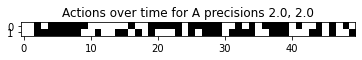

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(actions_over_time.T, cmap="gray")

plt.title(
    f"Actions over time for A precisions {precision_prosocial}, {precision_antisocial}"
)



In [ ]:

ax.set_yticks([0, 1], labels=["Agent 1", "Agent 2"])

plt.savefig("actions_over_time2")
from matplotlib.colors import LinearSegmentedColormap

cmap0 = LinearSegmentedColormap.from_list("", ["white", "darkblue"])

plt.subplot(1, 3, 1)
plt.imshow(B_over_time[0, :, :, 0], cmap=cmap0, vmin=0, vmax=1)
plt.yticks([0, 1], labels=["Cooperate", "Defect"])
plt.xticks([0, 1, 2, 3], labels=["CC", "CD", "DC", "DD"])

plt.subplot(1, 3, 2)
plt.imshow(B_over_time[10, :, :, 0], cmap=cmap0, vmin=0, vmax=1)
plt.xticks([0, 1, 2, 3], labels=["CC", "CD", "DC", "DD"])

plt.subplot(1, 3, 3)
plt.imshow(B_over_time[49, :, :, 0], cmap=cmap0, vmin=0, vmax=1)
plt.xticks([0, 1, 2, 3], labels=["CC", "CD", "DC", "DD"])

plt.savefig("B matrix over time agent 1 2")

plt.subplot(1, 3, 1)
plt.imshow(B_over_time[0, :, :, 1], cmap=cmap0, vmin=0, vmax=1)
plt.yticks([0, 1], labels=["Cooperate", "Defect"])
plt.xticks([0, 1, 2, 3], labels=["CC", "CD", "DC", "DD"])

plt.subplot(1, 3, 2)
plt.imshow(B_over_time[10, :, :, 1], cmap=cmap0, vmin=0, vmax=1)
plt.xticks([0, 1, 2, 3], labels=["CC", "CD", "DC", "DD"])

plt.subplot(1, 3, 3)
plt.imshow(B_over_time[49, :, :, 1], cmap=cmap0, vmin=0, vmax=1)
plt.xticks([0, 1, 2, 3], labels=["CC", "CD", "DC", "DD"])

plt.savefig("B matrix over time agent 2 2")